# 【第３回 課題5】 画像変換(2): CycleGAN

In [1]:
# UEC 共通設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"   # IEDの場合，必要に応じて指定(0-7)．未指定時はランダムに割り当てられる．

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else: 
    datadir="/usr/local/class/object/media/"

## CycleGAN

先ほどのPix2Pixは，エッジ画像と元画像のように学習データとして対応するペアが大量に必要でした．

それに対して，ここでは，カレーをラーメンに変換するような，対応するペアがない場合の変換を行います．

原理は次の通りです．画像ドメインAと画像ドメインBを考えて，A->B 変換ネットワークと B->A変換ネットワークを考えます．どちらもencoder-decoderです． A->Bに画像ドメインAに属する画像を入れると出力画像がドメインBの画像になるような制約を入れます．さらに，その画像を B->A変換器に入れると元の画像に戻るという制約も入れます．B->A, A->Bも同様です．

ドメインAをカレー，ドメインBを白ごはん　とした場合が以下の図になります．

<img src="fig/cyc.png" width=700>

変換して，逆変換すると元に戻るという制約で，ペア画像がなくても，２つのドメイン間での相互変換が可能となります．

実際の変換例を示します．

<img src="fig/cyc2.png" width=400>

もっと時間を掛けて学習すると．．．
<img src="fig/foodconv.png" with=800>

元の論文，Jun-Yan Zhu*, Taesung Park*, Phillip Isola, Alexei A. Efros:
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, ICCV2017.
では，以下のような，馬-シマウマ，りんご-オレンジ　変換を実現して話題になりました．

<img src="fig/cyc3.png" width=600>


### 食事相互変換実験

では，curry - rice のような変換をしてみましょう．

23種類から任意の２つを選んで試してみましょう．(データセットは課題３と同じです．データディレクトリを ls して確認することもできます．)

In [2]:
!ls /ced-home/staff/yanai/media/foodimg64    # CED の場合
!ls /usr/local/class/object/media/foodimg64 # IED の場合

ls: '/ced-home/staff/yanai/media/foodimg64' にアクセスできません: そのようなファイルやディレクトリはありません
bibimbap    curry     gyudon	 katsudon  omurice   pizza  soba    unadon
chahan	    ebichill  hiyachu	 meatspa   oyakodon  ramen  steak   yakisoba
chikenrice  gratin    kaisendon  omelet    pilaf     rice   tendon


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

using GPU: 2
Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# This code is based on https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division
import scipy

import keras
from keras.datasets import mnist
from keras_contrib.layers.normalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import time
import matplotlib.pyplot as plt
import sys
from data_loader_cy import DataLoader
import numpy as np
import os

Using TensorFlow backend.


In [5]:
# Input shape
img_size = 64
img_shape = (img_size, img_size, 3)

food_A="curry"  # domain A のカテゴリ
food_B="rice"  # domain B のカテゴリ

# Configure data loader
data_loader = DataLoader(datadir+"foodimg"+str(img_size),food_A,food_B,img_res=(img_size, img_size))

# Calculate output shape of D (PatchGAN)
patch = int(img_size / 2**4)
disc_patch = (patch, patch, 1)

# Number of filters in the first layer of G and D
gf = 32
df = 64

outdir='result/cycle_1/'
os.makedirs(outdir, exist_ok=True)

epochs=50  # うまく変換できない場合は epochs=100 としてみてください．
batch_size=64
sample_interval=200

In [6]:
def build_generator():
    """U-Net Generator"""

    def conv2d(layer_input, filters, f_size=4):
        """Layers used during downsampling"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        """Layers used during upsampling"""
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u

    # Image input
    d0 = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(d0, gf)
    d2 = conv2d(d1, gf*2)
    d3 = conv2d(d2, gf*4)
    d4 = conv2d(d3, gf*8)

    # Upsampling
    u1 = deconv2d(d4, d3, gf*4)
    u2 = deconv2d(u1, d2, gf*2)
    u3 = deconv2d(u2, d1, gf)
    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u4)

    return Model(d0, output_img)

In [7]:
def build_discriminator():

    def d_layer(layer_input, filters, f_size=4, normalization=True):
        """Discriminator layer"""
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d

    img = Input(shape=img_shape)

    d1 = d_layer(img, df, normalization=False)
    d2 = d_layer(d1, df*2)
    d3 = d_layer(d2, df*4)
    d4 = d_layer(d3, df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model(img, validity)

In [8]:
# Loss weight
lambda_cycle = 10.0                    # Cycle-consistency loss
lambda_id = 0.1 * lambda_cycle    # Identity loss

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminators
d_A = build_discriminator()
d_B = build_discriminator()
d_A.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])
d_B.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

#-------------------------
# Construct Computational
#   Graph of Generators
#-------------------------

# Build the generators
g_AB = build_generator()
g_BA = build_generator()

# Input images from both domains
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# Translate images to the other domain
fake_B = g_AB(img_A)
fake_A = g_BA(img_B)
# Translate images back to original domain
reconstr_A = g_BA(fake_B)
reconstr_B = g_AB(fake_A)
# Identity mapping of images
img_A_id = g_BA(img_A)
img_B_id = g_AB(img_B)

# For the combined model we will only train the generators
d_A.trainable = False
d_B.trainable = False

# Discriminators determines validity of translated images
valid_A = d_A(fake_A)
valid_B = d_B(fake_B)

# Combined model trains generators to fool discriminators
combined = Model(inputs=[img_A, img_B],
                              outputs=[ valid_A, valid_B,
                                        reconstr_A, reconstr_B,
                                        img_A_id, img_B_id ])
combined.compile(loss=['mse', 'mse',
                                    'mae', 'mae',
                                    'mae', 'mae'],
                            loss_weights=[  1, 1,
                                            lambda_cycle, lambda_cycle,
                                            lambda_id, lambda_id ],
                            optimizer=optimizer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def sample_images(epoch, batch_i):
    #os.makedirs('images/%s' % dataset_name, exist_ok=True)
    r, c = 3, 6

    titles = ['Original', 'Translated', 'Reconstructed']
    fig, axs = plt.subplots(r,c, figsize=(12,6))
    cnt = 0
    for i in range(r):
        imgs_A = data_loader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = data_loader.load_data(domain="B", batch_size=1, is_testing=True)

        # Translate images to the other domain
        fake_B = g_AB.predict(imgs_A)
        fake_A = g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = g_BA.predict(fake_B)
        reconstr_B = g_AB.predict(fake_A)
    
        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        cnt=0
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt])
            axs[i,j].set_title(titles[j%3])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("%s/%d_%d.png" % (outdir, epoch, batch_i))
    display.clear_output(wait = True)
    display.display(fig)
    plt.close()

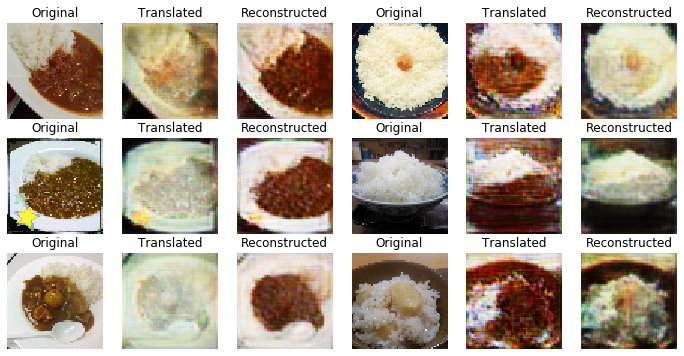

[Epoch 49/50] [Batch 5/15] [D loss: 0.116255, acc:  86%] [G loss: 5.670467, adv: 1.033834, recon: 0.161896, id: 0.172910] time: 441 
[Epoch 49/50] [Batch 10/15] [D loss: 0.142891, acc:  81%] [G loss: 6.144486, adv: 1.194441, recon: 0.170439, id: 0.171922] time: 443 


In [10]:
start = time.time()

# Adversarial loss ground truths
valid = np.ones((batch_size,) + disc_patch)
fake = np.zeros((batch_size,) + disc_patch)

for epoch in range(epochs):
    for batch_i, (imgs_A, imgs_B) in enumerate(data_loader.load_batch(batch_size)):
        # ----------------------
        #  Train Discriminators
        # ----------------------

        # Translate images to opposite domain
        fake_B = g_AB.predict(imgs_A)
        fake_A = g_BA.predict(imgs_B)

        # Train the discriminators (original images = real / translated = Fake)
        dA_loss_real = d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)

        dB_loss_real = d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)

        # Total disciminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)

        # ------------------
        #  Train Generators
        # ------------------

        # Train the generators
        g_loss = combined.train_on_batch([imgs_A, imgs_B],
                                                        [valid, valid,
                                                        imgs_A, imgs_B,
                                                        imgs_A, imgs_B])

        tm = time.time() - start

         # Plot the progress
        if batch_i % 5 == 0:
                print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %d " \
                                                                        % ( epoch, epochs,
                                                                            batch_i, data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            tm))

                # If at save interval => save generated image samples
        if batch_i % sample_interval == 0:
            sample_images(epoch, batch_i)

In [11]:
g_AB.save('%s/gen_%s2%s.h5' % (outdir,food_A,food_B))
g_BA.save('%s/gen_%s2%s.h5' % (outdir,food_B,food_A))
print("saved the models as '%s/gen_%s2%s.h5' and '%s/gen_%s2%s.h5'" % (outdir,food_A,food_B,outdir,food_B,food_A))

saved the models as 'result/cycle_1//gen_curry2rice.h5' and 'result/cycle_1//gen_rice2curry.h5'


## 課題５　

以下の小問の(1)(2)を解答せよ．**(課題提出には解答シートを使って下さい．)**

1. 23種類の中から好きな料理を２つ選んで食事画像変換モデルを学習せよ．64x64の場合は30分程度で学習できる．
1. 選んだ2種類の料理カテゴリの(学習に使っていない)自分で探した画像をそれぞれ5枚ずつ用意して変換してみよ．変換方法は，課題４の学習済モデルからの画像生成を参考にせよ．

In [12]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()